## Morning practical 2 day 4

You'll now make the switch to hierarchical clustering. I wanted to let you implement it yourself, but that would probably take somewhat too long for a short practical. Still, average linkage clustering is implemented for you, but you' ll have to edit it to also allow complete and single linkage clustering. Finally, you make a small comparison between K-means clustering and hierarchical clustering. To get started, run the two cells below.

In [146]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown
import sklearn
from sklearn.datasets import make_blobs
import itertools

In [147]:
def calcEucliDist(vectorOne, vectorTwo):
    return np.linalg.norm(vectorOne-vectorTwo, axis = 1)

def calcAbsDist(vectorOne, vectorTwo):
    #using linalg.norm:
    return np.linalg.norm(vectorOne-vectorTwo, ord = 1, axis = 1)

def makeKMeanClusters(X, k, funName = "calcEucliDist", maxIter = 50, nClusteringsToPerform = 20):
    if k <= 0:
        print("K must be greater than 0!")
        return None
    if k > len(X):
        print("K cannot be larger than the # of samples in your data!")
        return None
    if maxIter <= 0:
        print("Cannot have negative or 0 iterations!")
        return None
    
    resultToReturn = [None, None, None, None]
    bestDistortion = np.Inf
    
    for clusteringIndex in range(0, nClusteringsToPerform):
        initialCentroids   = X[np.random.choice(X.shape[0], k, replace=False), :]
        if len(initialCentroids) != k:
            print("Centroids lost!")
        centroids          = initialCentroids
        threeLastCentroids = []
        #print(centroids)
        for i in range(0, maxIter):

            threeLastCentroids.append(np.round(centroids, 4))
            distancesToCentroids = np.vstack([globals()[funName](centroids, datapoint) for datapoint in X])
            closestCentroid      = np.where(distancesToCentroids == np.amin(distancesToCentroids,
                                                                            axis = 1)[:, np.newaxis])[1]
            centroids            = np.vstack([np.mean(X[np.where(closestCentroid == clusterNum)],
                                                      axis = 0) for clusterNum in np.unique(closestCentroid)])

            if i >2:
                threeLastCentroids.pop(0)
                if np.array_equal(threeLastCentroids[-1],threeLastCentroids[-2]) and np.array_equal(threeLastCentroids[-2], threeLastCentroids[-3]):
                    print("No changes in cluster centroids detected in last 3 iterations. Finished at iteration " + str(i+1) + ".")
                    break
        
        # new code
        squareDistancesPerPoint = []
        for index, centroid in enumerate(closestCentroid):
            squareDistancesPerPoint.append(np.square(centroids[centroid, :] - X[index, :]))
        distortion = 1/len(X) * np.sum(np.array(squareDistancesPerPoint))
        
        if distortion < bestDistortion:
            bestDistortion = distortion
            resultToReturn = [centroids, closestCentroid, initialCentroids, bestDistortion]
                
    return resultToReturn

## Sample data

The below again defines some clusters for you to work with. Run it, then  move on to the next cell.

<AxesSubplot:xlabel='Feature 1', ylabel='Feature 2'>

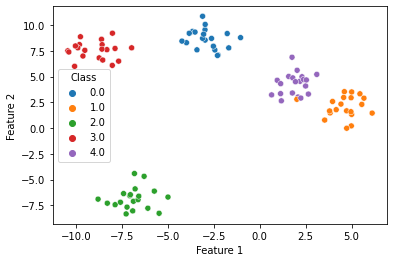

In [148]:
X, y = make_blobs(n_samples=100, n_features=2, centers=5, cluster_std=1.0,
                  center_box=(- 10.0, 10.0), shuffle=True, random_state=42, return_centers=False)

dataFrameForPlot = pd.DataFrame(np.c_[X, y])
dataFrameForPlot.columns = ["Feature 1", "Feature 2", "Class"]
sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = "Class", palette = "tab10", data = dataFrameForPlot)


## Hierarchical clustering with average linking

Let's start simple by doing hierarchical clustering using average linking. To do this, you need the following:
1. Distances from all points to all other points
2. A way to link the two closest clusters and save that as a new cluster.

Below, I give you a basic function body that calculates the distance matrix for every point to every other point. Since this is a symmetric matrix (distance from point 1 to point 2 = distance from point 2 to point 1) and the distance from each point to itself is 0, I make sure not to calculate superfluous values. Then, it implements average linkage clustering. Read through the function body and see if you understand what it is doing. After that's done, go to the cell below it to test it out on our sample data!


In [149]:
def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            totalDistance = 0
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    totalDistance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                # you'll fill these in later to make complete and single linkage work!
                if linkageMethod == "complete":
                    furthestDistance = None
                if linkageMethod == "single":
                    closestDistance  = None

            if linkageMethod == "average":
                totalAvgDistance = totalDistance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            # again, you'll fill these in later.
            if linkageMethod == "complete":
                distToCluster = None
                dataPointsToCluster = None

            if linkageMethod == "single":
                distToCluster = None
                dataPointsToCluster = None

        clusterIndicesMergedList.append(dataPointsToCluster)
        #make a new list of clusters
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster)         
        clusteringOverIterations.append(clusterList)
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]

## Testing the hierarchical clustering function. 

As you've heard, hierarchical clustering doesn't result in a certain set of clusters like K-means does. Instead, it gives all intermediate amounts of clusters, starting with everything in a separate cluster and agglomerating until everything is in one cluster. The below sets up a variable with a list of all these clusterings. We know there are 5 clusters in our data, so it is interesting to see what things look like if we request 10 clusters. Do those resemble the 5 clusters in the data, with 5 outlier points not yet connected up? It is up to you to:

* Select the element of that list that has 10 clusters in it
* Make a list where you give each data point in X a number from 0 to 9, indicating to which of the 10 clusters it belongs
* Plot the data with seaborn, using `hue = yourClusterMembershipVariableFrom0To9`.
* Plot the plot with the original cluster colouring below it for comparison. You should see that only the one orange point that is right in the middle of the purple cluster in the original data is 'misclassified' (that is, there's of course ten clusters here, but it's obvious that they'll be merged into the 5 'correct' clusters, save for this one outlier datapoint that is orange officially but lies smack in the middle of the purple cluster).

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99]]
100
[[0, 65, 5, 47, 63, 40, 96, 53, 72, 11, 81, 92, 18, 68, 73, 71, 23, 30, 79, 94, 1, 16, 50, 28, 78, 56, 67, 80, 66, 49, 17, 33, 3, 27, 12, 26, 57, 34, 32, 74, 69, 6, 52, 76, 7, 60, 99, 39, 41, 43, 8, 83, 42, 54, 14, 98, 51, 21, 29, 93, 2, 9, 13, 10, 61, 88, 36, 38, 46, 59, 58, 37, 91, 22, 85, 89, 97, 87, 45, 95, 4, 35, 25, 84, 15, 48, 44, 20, 31, 75, 19, 24, 82, 86, 64, 77, 55, 90, 62, 70]]
99


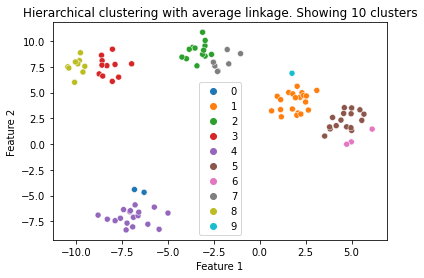

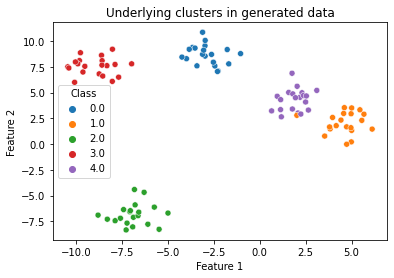

In [150]:
clusteringOutcomeX = hierarCluster(X)
clusterListX       = clusteringOutcomeX[0]

#print the clusters where everything is separate and everything is combined
print(clusterListX[0])
print(len(clusterListX[0]))
print(clusterListX[-1])
print(len(clusterListX[1]))

#answer
for clustering in clusterListX:
    if len(clustering) == 10:
        tenClusters = clustering

clusterMembership = [0] * len(X)
for clusterNr, cluster in enumerate(tenClusters):
    for dataIndex in cluster:
        clusterMembership[dataIndex] = clusterNr

b = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                palette = "tab10", data = dataFrameForPlot).set(title = "Hierarchical clustering with average linkage. Showing 10 clusters")
plt.show(b)
plt.show(sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = "Class",
                palette = "tab10", data = dataFrameForPlot).set(title = "Underlying clusters in generated data"))

## Plotting the clustering process

Let's plot the process from start to finish, in steps of five clusters being added together. To avoid cluttering the legend with up to 100 different clusters, assign everything that has not been clustered with any other point the label 'not clustered'. Up to you to:

*  Do what you did above, but do it for every entry in `toPlot`.

Hints:
* You can use `myPlot = sns.scatterplot()` to make it callable. Then, using `plt.legend(loc = 2, bbox_to_anchor = (1,1))` followed finally by `plt.show(myPlot)` you can put the legend outside of the plot and show it. Handy when you have loads of clusters.
* To do this you just need another loop around your code above that goes over the indices you need to get out of the list of clusters.


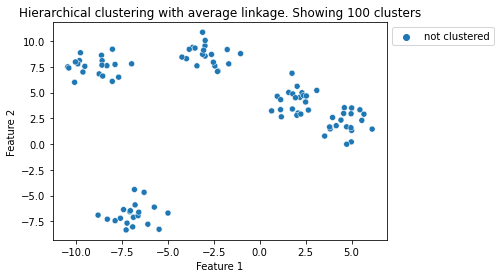

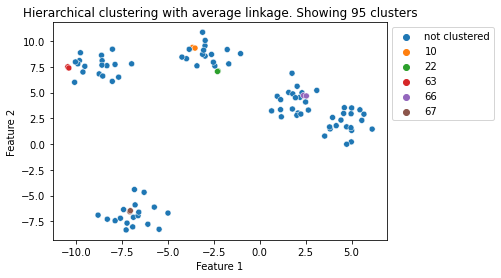

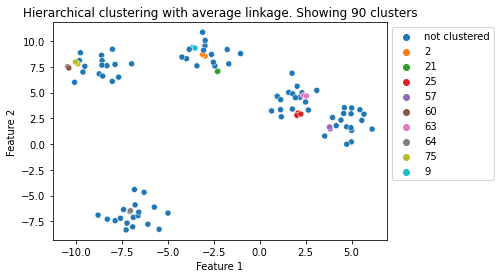

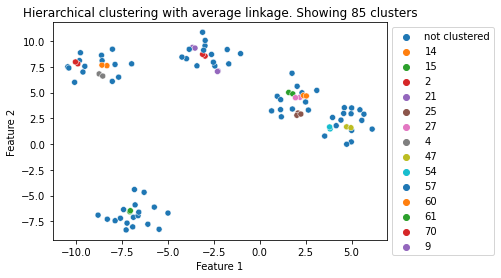

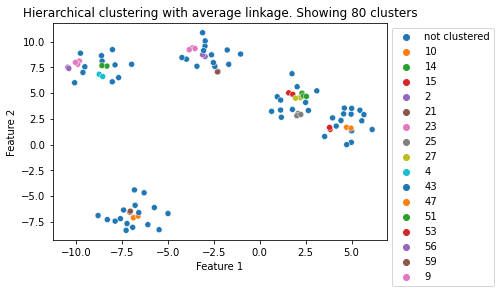

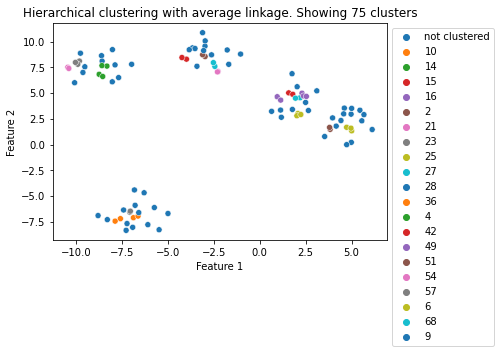

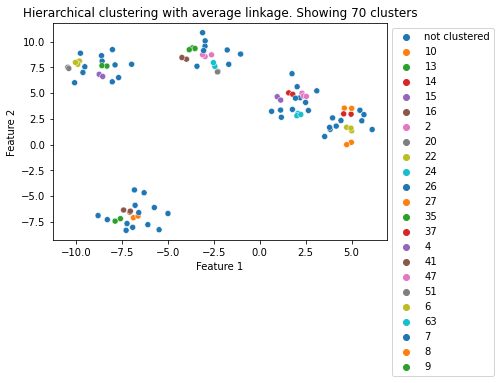

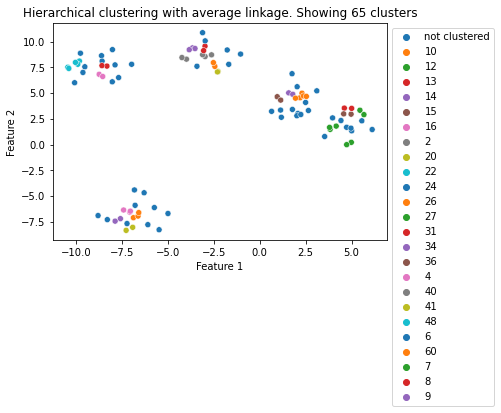

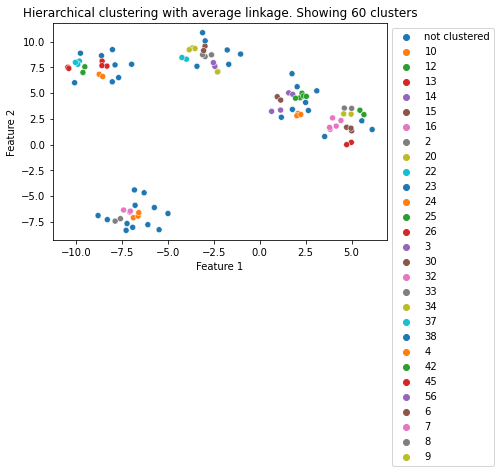

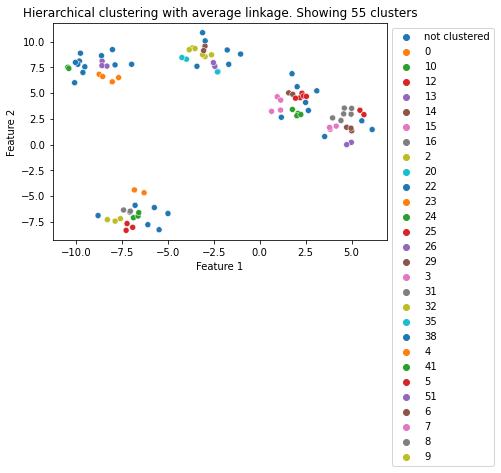

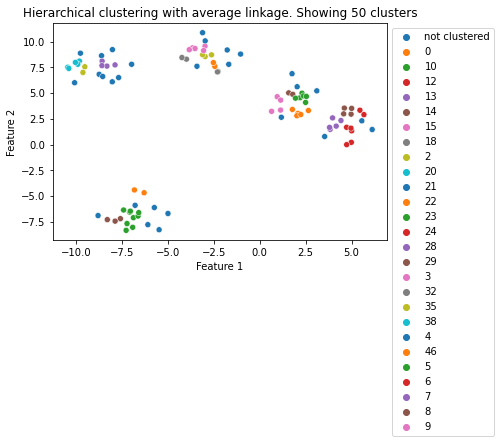

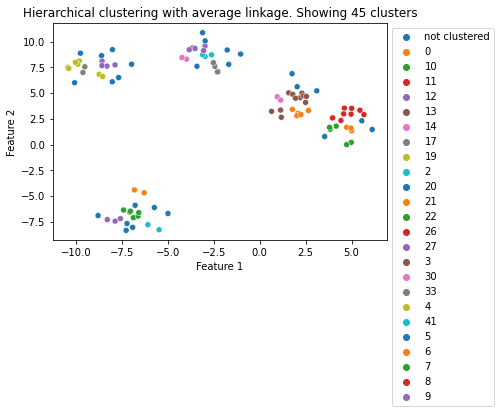

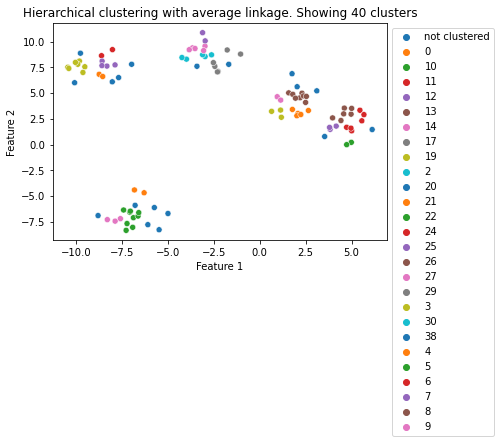

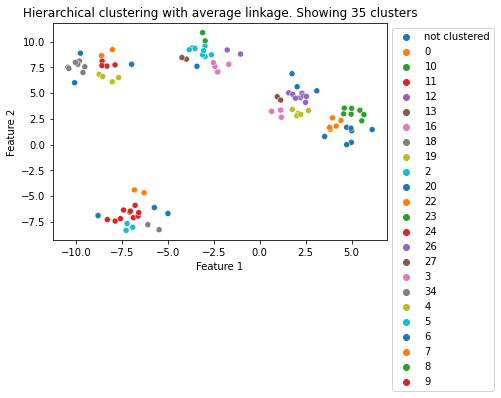

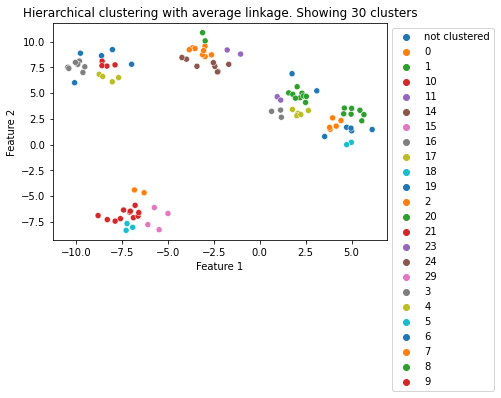

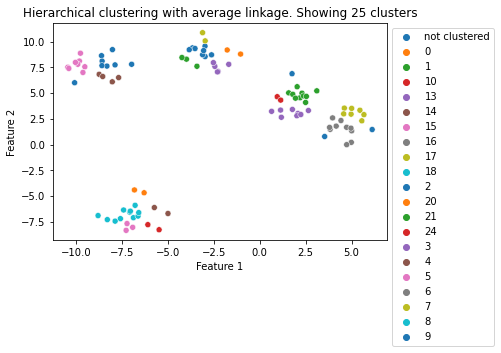

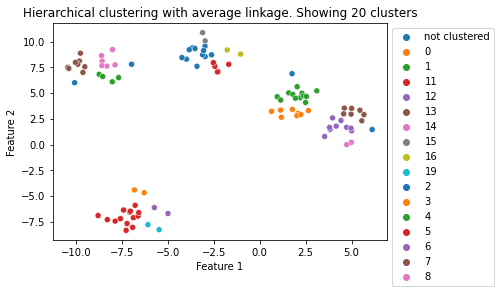

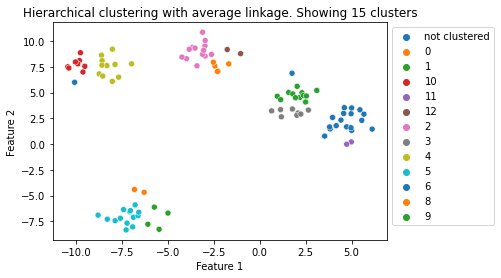

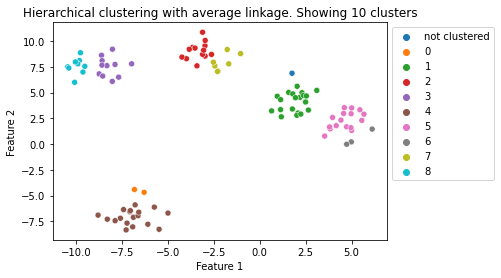

ValueError: list.remove(x): x not in list

In [9]:
toPlot = list(range(0, len(clusterListX), 5))

# answer

for indexToPlot in toPlot:
    
    clusterMembership = [0] * len(X)
    for clusterNr, cluster in enumerate(clusterListX[indexToPlot]):
        if len(cluster) == 1:
            clusterMembership[cluster[0]] = 'not clustered'
        else:            
            for dataIndex in cluster:
                #print(dataIndex)
                #print(X[dataIndex,:])
                clusterMembership[dataIndex] = str(clusterNr)
    entries = list(np.unique(clusterMembership))
    entries.remove('not clustered')
    hue_order = ["not clustered"] + entries
    b = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                    palette = "tab10", data = dataFrameForPlot, hue_order = hue_order).set(title = "Hierarchical clustering with average linkage. Showing " + str(len(clusterListX[indexToPlot]))+ " clusters")
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show(b)

## Making complete and single linkage clusters

Before we get to drawing a tree-like diagram of the clusters, let's make the function completely functional. It's up to you to make sure that when the argument is `"single"`, the shortest distance between clusters is chosen as their distance to see whether these need to be clustered together in the next step (rather than the average distance). Then, do the same for `"complete"` linkage. I've copied the function below, up to you to change it!

Hints:
* If you get stuck, remember that you can just take everything out of the function body while building the function, and only as a last stap do the `def hierarCluster` etc. In that way, you can investigate the intermediate steps easily.
* For single linkage, you might not want the initial distance to start at 0. After all, to get the closest two points in a cluster, you'll continuously be asking whether the distance between to points is less than the current lowest distance you have for that cluster.
* For both single linkage and complete linkage, you eventually cluster the clusters that have the lowest distance between them. It only differs how you define the lowest distance between clusters (the smallest distance between all points in them, or the largest distance between all points in them)

In [50]:
def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            totalDistance = 0
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    totalDistance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                # you'll fill these in later to make complete and single linkage work!
                if linkageMethod == "complete":
                    furthestDistance = None
                if linkageMethod == "single":
                    closestDistance  = None

            if linkageMethod == "average":
                totalAvgDistance = totalDistance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            # again, you'll fill these in later.
            if linkageMethod == "complete":
                distToCluster = None
                dataPointsToCluster = None

            if linkageMethod == "single":
                distToCluster = None
                dataPointsToCluster = None

        clusterIndicesMergedList.append(dataPointsToCluster)
        #make a new list of clusters
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster)         
        clusteringOverIterations.append(clusterList)
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]

        
# answer

def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            distance = 0
            distanceSingleLink = np.Inf # need this because for single linkage you want lowest distance to be selected
                                        # so need to have the starting distance always be lower.
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    distance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "complete":
                    # for a cluster, if the distance between two points is larger than the current largest distance
                    # between points in a cluster, that is the new cluster distance.
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] > distance:
                        distance = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "single":
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] < distanceSingleLink:
                        distanceSingleLink = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]

            if linkageMethod == "average":
                totalAvgDistance = distance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            if linkageMethod == "complete":
                if distance < distToCluster:
                    distToCluster       = distance
                    dataPointsToCluster = combo

            if linkageMethod == "single":
                if distanceSingleLink < distToCluster:
                    distToCluster       = distanceSingleLink
                    dataPointsToCluster = combo

        #make a new list of clusters
        clusterIndicesMergedList.append(dataPointsToCluster)
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster) in one list by appending to that the current clusters      
        clusteringOverIterations.append(clusterList)
        
        #addition to make a list of lists of everything:
        
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]

        
    

## Testing your new function

It'll be interesting to see what single linkage and complete linkage result in, relative to average linkage. In the code cell below, I run hierarchical clustering on the sample data (X), and select the list entry that has 5 clusters. Up to you to plot the clusters. See whether they have the same result or are dissimilar at all.

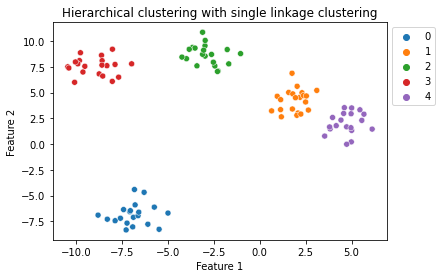

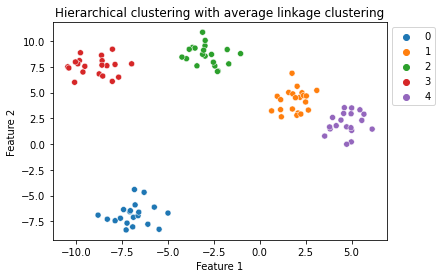

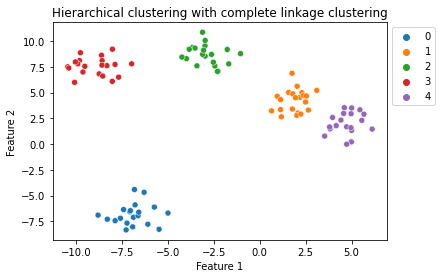

In [24]:
singleLinkCluster   = hierarCluster(X, linkageMethod = "single")[0]
averageLinkCluster  = hierarCluster(X, linkageMethod = "average")[0]
completeLinkCluster = hierarCluster(X, linkageMethod = "complete")[0]

fiveClusterData = [elem for elem in singleLinkCluster if len(elem) == 5 ] + [elem for elem in averageLinkCluster if len(elem) == 5 ] + [elem for elem in completeLinkCluster if len(elem) == 5]

#answer
clusterNameList = ["single linkage", "average linkage", "complete linkage"]
for index, clustering in enumerate(["single linkage", "average linkage", "complete linkage"]):
    clusterMembership = [0] * len(X)
    for clusterIndex, cluster in enumerate(fiveClusterData[index]):
        for dataIndex in cluster:
            clusterMembership[dataIndex] = str(clusterIndex)
    b = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                    palette = "tab10", data = dataFrameForPlot).set(title = "Hierarchical clustering with " + clustering)
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show(b)


## Intermediate steps

You probably found out that for these well-defined clusters nothing much is different for the final clustering into five clusters. Let's look at the case for when there's still 15 clusters. That will probably look drastically different. No use to let you program that, so just run the code cell below. Also it's again not very DRY (Don't Repeat Yourself) what I am doing here, but it's for demonstration purposes. Normally you would functionalise your plotting calls!

We've so far been using Euclidean distance. It makes most sense intuitively here. What if we would use the Manhattan distance instead? You can see the results for that below as well!

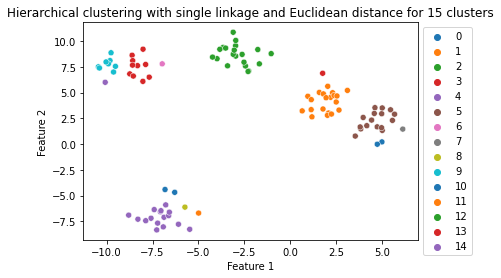

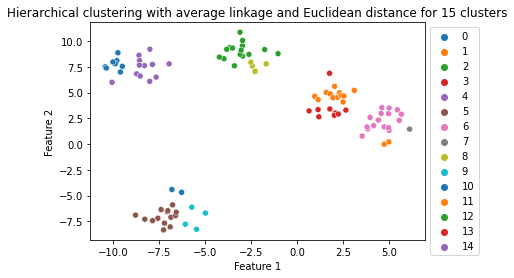

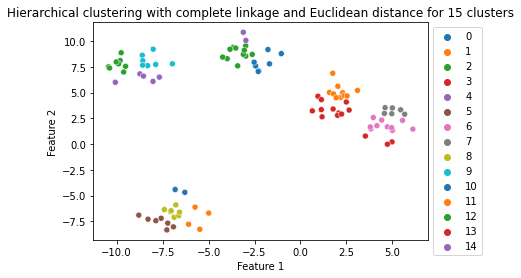

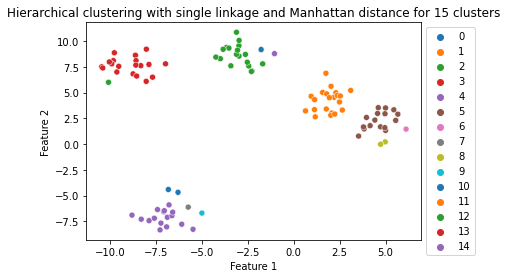

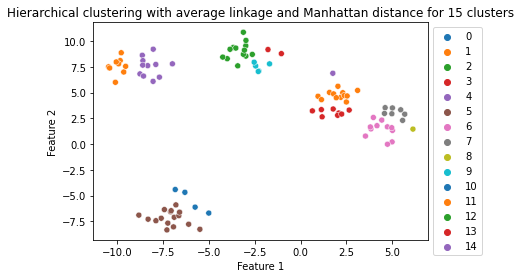

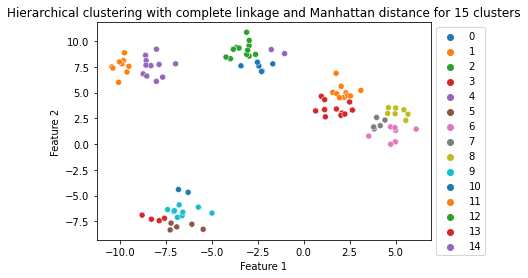

In [32]:
singleLinkManhattanCluster   = hierarCluster(X, distanceFunc = "calcAbsDist", linkageMethod = "single")[0]
averageLinkManhattanCluster  = hierarCluster(X, distanceFunc = "calcAbsDist", linkageMethod = "average")[0]
completeLinkManhattanCluster = hierarCluster(X, distanceFunc = "calcAbsDist", linkageMethod = "complete")[0]

clusterLen = 15
fifteenClusterData = [elem for elem in singleLinkCluster if len(elem) == clusterLen ] + [elem for elem in averageLinkCluster if len(elem) == clusterLen ] + [elem for elem in completeLinkCluster if len(elem) == clusterLen]
fifteenClusterDataManhattan = [elem for elem in singleLinkManhattanCluster if len(elem) == clusterLen ] + [elem for elem in averageLinkManhattanCluster if len(elem) == clusterLen ] + [elem for elem in completeLinkManhattanCluster if len(elem) == clusterLen]

clusterNameList = ["single linkage and Euclidean distance", "average linkage and Euclidean distance", "complete linkage and Euclidean distance"]
for index, clustering in enumerate(clusterNameList):
    clusterMembership = [0] * len(X)
    for clusterIndex, cluster in enumerate(fifteenClusterData[index]):
        for dataIndex in cluster:
            clusterMembership[dataIndex] = str(clusterIndex)
    b = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                    palette = "tab10", data = dataFrameForPlot).set(title = "Hierarchical clustering with " + clustering + " for " + str(clusterIndex + 1) + " clusters")
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show(b)
    
    
#answer
clusterNameList = ["single linkage and Manhattan distance", "average linkage and Manhattan distance", "complete linkage and Manhattan distance"]
for index, clustering in enumerate(clusterNameList):
    clusterMembership = [0] * len(X)
    for clusterIndex, cluster in enumerate(fifteenClusterDataManhattan[index]):
        for dataIndex in cluster:
            clusterMembership[dataIndex] = str(clusterIndex)
    b = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                    palette = "tab10", data = dataFrameForPlot).set(title = "Hierarchical clustering with " + clustering + " for " + str(clusterIndex + 1) + " clusters")
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show(b)

## What you see

What you should see is that points that are close to others 'diagonally' are indeed close in the Euclidean distance case, but not in the Manhattan distance case. 

## Drawing a dendogram

You might want to plot a nice tree diagram of your clusters. How to do that? Well, you need to draw lines connecting all data points together. Let's try it. Run the code below to generate such a plot. Note that it is not _completely_ the same as a normal dendogram, because I didn't draw the connecting line in the middle of each horizontal line, but at the average position of all indices in a cluster. Still, close enough for homemade!

My question to you: in the final clustering steps of this clustering procedure you see that there's two clusters of two subclusters each that get clustered together, which are then finally clustered together with the cluster on the left. Which of the 5 cluster signals we put into our data is each of these likely to be? What is the outlier?

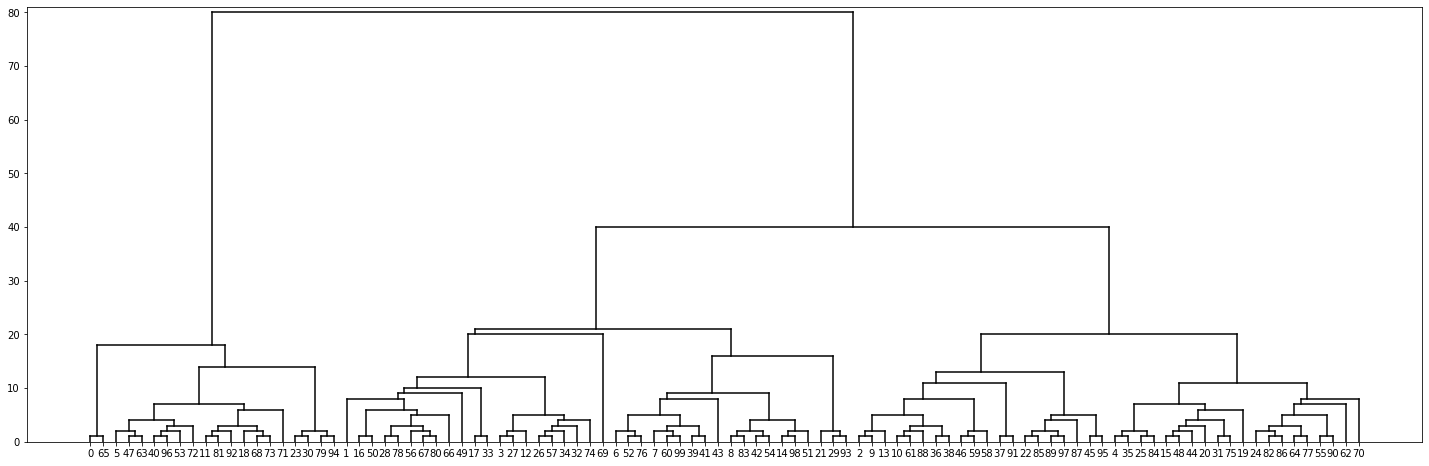

<AxesSubplot:xlabel='Feature 1', ylabel='Feature 2'>

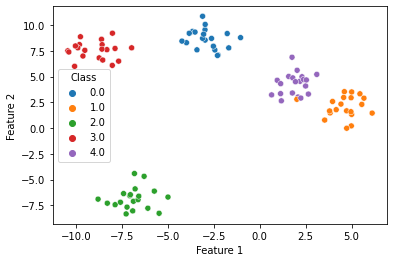

In [145]:
clusteringOutcomeX = hierarCluster(X)
clusterListX       = clusteringOutcomeX[0]
clusteredPerStepX  = clusteringOutcomeX[2]
xLabels            = np.array(list(itertools.chain(*clusterListX[-1])))

fig, ax = plt.subplots(figsize = (25, 8))
ax.set_xticks(range(0, len(X)))
ax.set_xticklabels(xLabels)
ax.margins(y=0)

heightPerDataPointPreviousStep = np.array([0] * len(X))
for i, clusterStep in enumerate(clusteredPerStepX):
    pos1Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[0]])
    pos1Avg       = np.mean(pos1Positions)
    #pos1Start     = np.min(pos1Positions)
    #pos1End       = np.max(pos1Positions)
    pos1ClustSize = len(pos1Positions)
    pos2Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[1]])
    pos2Avg       = np.mean(pos2Positions)
    #pos2Start     = np.min(pos2Positions)
    #pos2End       = np.max(pos2Positions)
    pos2ClustSize = len(pos2Positions)
    

    
    heightEnd   = max(pos1ClustSize, pos2ClustSize)
    ax.plot([pos1Avg, pos1Avg], [heightPerDataPointPreviousStep[pos1Positions[0][0]],heightEnd], color = "black")
    ax.plot([pos2Avg, pos2Avg], [heightPerDataPointPreviousStep[pos2Positions[0][0]],heightEnd], color = "black")
    ax.plot([pos1Avg, pos2Avg], [heightEnd,heightEnd], color = "black")
    
    heightPerDataPointPreviousStep[np.ravel(pos1Positions)] += heightEnd - heightPerDataPointPreviousStep[pos1Positions[0][0]]
    heightPerDataPointPreviousStep[np.ravel(pos2Positions)] += heightEnd - heightPerDataPointPreviousStep[pos2Positions[0][0]]
    
ax.set_ylim(0, max(heightPerDataPointPreviousStep)+1)
 
plt.show(fig)
sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = "Class", palette = "tab10", data = dataFrameForPlot)

## Cluster method comparison

Finally, let's see how average linkage hierarchical clustering and K-means clustering compare. Run k-means clustering with 10 centroids on this data and visualise the results. Also run hierarchical clustering and select the clustering step where there's 10 clusters remaining (you did this as the first exercise, so you can just replot the plot from there). Is there much difference?

No changes in cluster centroids detected in last 3 iterations. Finished at iteration 7.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 7.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 6.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 8.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 6.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 8.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 5.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 4.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 9.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 6.
No changes in cluster centroids detected in last 3 iterations. Finished at iteration 10.
No changes in cluster centroids

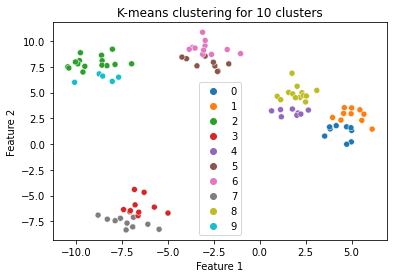

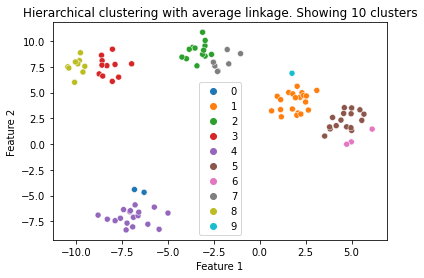

In [155]:
#your answer here!


#answer

# K-means

tenKClusters = makeKMeanClusters(X, 10)
kMeanPlot = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = tenKClusters[1], palette="tab10", data = dataFrameForPlot)
kMeanPlot.set(title = "K-means clustering for 10 clusters")
plt.show(kMeanPlot)

# copy of hierarchical clustering beginning of notebook:
for clustering in clusterListX:
    if len(clustering) == 10:
        tenClusters = clustering

clusterMembership = [0] * len(X)
for clusterNr, cluster in enumerate(tenClusters):
    for dataIndex in cluster:
        clusterMembership[dataIndex] = clusterNr

hierarchPlot = sns.scatterplot(x = "Feature 1", y = "Feature 2", hue = clusterMembership,
                palette = "tab10", data = dataFrameForPlot).set(title = "Hierarchical clustering with average linkage. Showing 10 clusters")
plt.show(hierarchPlot)



## Differences

If you look at the plots for a while, you see that there's some agreement, but they're clearly not the same. For this data, we _know_ that there's 5 underlying distributions of feature 1 and 2 that generated the data, i.e. the correct answer is that there are 5 clusters. In reality, you wouldn't know. So if we pretend there's 10, searching around as you would in a real situation, you see there's quite some differences in the clusters K-means would give you versus those made with hierarchical clustering.

A clear example is the cluster in the top left: here, I would say hierarchical clustering has got a better handle on things in this case: K-means separates the clusters into top and bottom, which feels visually off. It's probably a result of its random initialisation never starting such that there's not one centroid more in the upper part of that cluster and another more to the bottom. Note also that K-means equally subdivides clusters that to us look like they should be whole, whereas hierarchical clustering has basically the 5 clusters we would expect, with 5 outlier points of those clusters not quite yet added to the main blob.

In the end, there's no correct answer, it doesn't exist (especially in this case, given the signal we put in), but there's many different possibilities of clustering even these quite simple data clouds into 10 clusters. Remember that clustering is a dialogue with your data, guided by what you find important or useful, and/or what you need for downstream purposes, and can thus be an informed choice at most. There's no single objectively best clustering. 

## What I want you to remember here:
* What hierarchical clustering is and how it works
* How it differs from K-means clustering
* How a dendrogram relates to a hierarchical clustering
* The points below

## The end

That's it for this practical. Some takeaways:
* Hierarchical clustering starts with every data point in its own cluster, and agglomerates, merging clusters 1 by 1, until everything is in one cluster.
* This means it's very easy to get any number of clusters, you just request a different intermediate step that's done anyway. For K-means, you'd have to rerun for different K.
* Note also that hierarchical clustering (at least with these linkage and distance methods) is fully deterministic: there's just one result for hierarchical clustering using average linkage on the sample data used here. For K-means, depending on how you initialise you get different results.
* I hope that seeing these algorithms defined in code makes sure that you appreciate that you can understand exactly what they're doing and why, and could do it yourself if need be and you had the time. Try to always understand what clustering algorithms are doing exactly before using them in the wild, and more generally: accept that clustering is not some quick step but is an iterative process.

## Survey
[Hallelujah, praise the Forms!](https://docs.google.com/forms/d/e/1FAIpQLScx9hq233cl8wKw8ws6stN3dSzTKRtN8eP3gtHtuk8Ywg5fEQ/viewform?usp=sf_link)